### Prepare Data
- convert categorical fields to dummies
- normalize data
- test/train/validation set split
    - use the last 3-4 years for testing and validation

### Train and Evaluate
- Train the model using 1) RandomForest and 2) XGBoost
- Evaluate the predictions agains the test set

### Prediction API
- Implement a function that takes raw data as input and produces the hourly predictions
    - implement a function that converts the dummies back to categorical
    - denormalize the data back to the original scale    

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime
from sklearn import model_selection, preprocessing, ensemble
%matplotlib inline

In [147]:
# data parameters
categorical_columns = ["vehicle_type", "location_id", "direction", "weekday", "week"]
dependent_columns = ["hour_{}".format(n) for n in range(1,25)]

# functions
def to_train_format(raw_data):
    """
    Converts categorical fields to dummies (and normalizes the values).
    Returns a DataFrame.
    """
    data = raw_data
    for col in categorical_columns:
        dummies = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data, dummies], axis=1)
        data = data.drop([col], axis=1)
    return data

def train_test_split(data, test_size=0.10):
    """
    Splits the formatted data into train and test sets.
    Returns X and Y + associated test sets as DataFrames.
    """
    X = data.drop(dependent_columns, axis=1)
    Y = data[dependent_columns]
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size)
    return X_train, X_test, Y_train, Y_test

def train(X_train, Y_train, model):
    """
    Fits the model to the train data.
    Modifies the model parameter.
    """
    model.fit(X_train, Y_train)
    model.features = X_train.columns
    model.targets = Y_train.columns

def evaluate(X_test, Y_test, model):
    """
    Returns the coefficient of determination R^2 of the prediction.
    """
    score = model.score(X_test, Y_test)
    return score

def predict(row, model):
    """
    Uses the trained model to predict with the given DataFrame.
    Returns a DataFrame including the predictions.
    """
    row_f = to_train_format(row)
    row_formatted = pd.DataFrame()
    for col in model.features:
        if col in row_f.columns:
            row_formatted[col] = row_f[col]
        else:
            row_formatted[col] = 0
    pred = pd.DataFrame(model.predict(row_formatted))
    pred.columns = model.targets
    return pred

def sample_prediction(sample_data, model):
    """
    Generates the prediction of a sample item.
    Returns a DataFrame containing the original and the 
    predicted values side-by-side.
    """
    sample = sample_data.sample(1)
    result = pd.concat([sample, predict(sample, model)]).fillna("").transpose()
    index = result.columns[0]
    result.columns = [index, "prediction"]
    return result

def generate_prediction_series(
        model,
        dates=["2018-06-21", "2018-06-22", "2018-06-23", "2018-06-24", "2018-06-25", "2018-06-26"], 
        location_ids=[168, 1403, 110],
        vehicle_types=["13 Linja-autot", "12 KAIP", "11 HA-PA"],
    ):
    """
    Generates a predicted data series for the given dates, 
    locations, and vehicle types. Returns a DataFrame.
    """
    generated = pd.DataFrame()
    for date_str in dates:
        date = parser.parse(date_str)
        for location_id in location_ids:
            for vehicle_type in vehicle_types:
                for direction in [1,2]:
                    row = pd.DataFrame()
                    row["year"] = [date.year]
                    row["week"] = [date.isocalendar()[1]]
                    row["weekday"] = [date.weekday()]
                    row["location_id"] = [location_id]
                    row["direction"] = [direction]
                    row["vehicle_type"] = [vehicle_type]
                    #row["temperature"] = [15]
                    #row["rain"] = [0]
                    prediction = predict(row, model)
                    prediction.columns = dependent_columns
                    combined = pd.concat([row, prediction], axis=1)
                    generated = generated.append(combined, ignore_index=True)
    return generated

def get_location_name(location_id):
    """
    Returns the LAM station name of a location_id.
    """
    names = {168: "Askisto", 1403: "Kemijärvi", 110: "Mäntsälä"}
    return names[location_id]

def get_ts_row(data, location_id, year, week, weekday, hour):
    """
    Returns time series formatted row from the data.
    """
    ts_row = pd.DataFrame()
    rows = data[(data.location_id == location_id) & (data.year == year) & (data.week == week) & (data.weekday == weekday)]
    cars_1 = rows[(rows.vehicle_type == "11 HA-PA") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    cars_2 = rows[(rows.vehicle_type == "11 HA-PA") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    trucks_1 = rows[(rows.vehicle_type == "12 KAIP") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    trucks_2 = rows[(rows.vehicle_type == "12 KAIP") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    buses_1 = rows[(rows.vehicle_type == "13 Linja-autot") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    buses_2 = rows[(rows.vehicle_type == "13 Linja-autot") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    # shift weekday and week so that sunday is 0 and saturday is 6
    weekday -=1
    if weekday == 0:
        week -= 1
    if weekday == -1:
        weekday = 6
        week -= 1
    date = datetime.strptime("{}-{}-{}".format(year, week, weekday), "%Y-%W-%w")
    ts_row["date"] = [date]
    ts_row["hour"] = "{:02}-{:02}".format(hour-1, hour)
    ts_row["LAM Station"] = [get_location_name(location_id)]
    ts_row["Cars and Vans - 1"] = cars_1
    ts_row["Cars and Vans - 2"] = cars_2
    ts_row["Trucks - 1"] = trucks_1
    ts_row["Trucks - 2"] = trucks_2
    ts_row["Buses - 1"] = buses_1
    ts_row["Buses - 2"] = buses_2
    return ts_row

def to_ts_format(data):
    """
    Converts the given dataset (of training or generating format) 
    to time series format. Returns a DataFrame.
    """
    ts_data = pd.DataFrame()
    for location_id in data.location_id.unique():
        for year in data[data.location_id == location_id].year.unique():
            for week in data[(data.location_id == location_id) & (data.year == year)].week.unique():
                for weekday in data[(data.location_id == location_id) & (data.year == year) & (data.week == week)].weekday.unique():
                    for hour in range(1,25):
                        row = get_ts_row(data, location_id, year, week, weekday, hour)
                        ts_data = pd.concat([ts_data, row])
    return ts_data.reset_index()
    

In [27]:
# split the raw data to train and test sets
raw_data = pd.read_csv("refined_dataset.csv").sort_values(by="date")
raw_data = raw_data.drop(["sum", "location_name", "date"], axis=1)

model_data = raw_data[:-100]
validation_data = raw_data[-100:]

train_formatted_data = to_train_format(model_data)
X_train, X_test, Y_train, Y_test = train_test_split(train_formatted_data)

# random forest regression model
model = ensemble.RandomForestRegressor()

# train the model
train(X_train, Y_train, model)

# evaluate the model
evaluate(X_test, Y_test, model)

0.97468412948568428

In [33]:
# predict a sample
sample_prediction(model_data[(model_data["week"] == 25) & (model_data["weekday"] == 3)], model)

,21842,prediction
direction,1,
hour_1,103,116.1
hour_10,1222,1275.2
hour_11,1784,1728.5
hour_12,2115,1967.9
hour_13,2376,2212.7
hour_14,2710,2521.6
hour_15,2792,2570.8
hour_16,2799,2711.4
hour_17,2100,2576.3


In [7]:
model_data.head()

,location_id,direction,vehicle_type,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,year,weekday,week
35913,110,2,11 HA-PA,55.0,72.0,53.0,46.0,30.0,32.0,40.0,...,569.0,548.0,454.0,311.0,220.0,131.0,91.0,2010,4,53
35919,110,2,17 HA + AV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,0.0,1.0,0.0,2010,4,53
35918,110,2,16 HA + PK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,11.0,6.0,5.0,4.0,1.0,0.0,0.0,2010,4,53
35917,110,2,15 KATP,5.0,1.0,8.0,3.0,5.0,2.0,2.0,...,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2010,4,53
35916,110,2,14 KAPP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2010,4,53


In [148]:
generated = generate_prediction_series(model)
generated.head()

,year,week,weekday,location_id,direction,vehicle_type,hour_1,hour_2,hour_3,hour_4,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2018,25,3,168,1,13 Linja-autot,1.2,1.8,0.2,1.6,...,5.0,4.4,7.0,5.8,4.4,3.8,4.6,5.4,3.8,2.4
1,2018,25,3,168,2,13 Linja-autot,3.7,3.7,0.2,1.1,...,3.8,3.7,4.8,3.7,3.4,2.9,3.8,1.4,1.3,3.7
2,2018,25,3,168,1,12 KAIP,8.1,9.0,13.8,13.8,...,116.2,105.6,66.2,52.9,33.6,31.5,15.0,15.1,8.3,5.8
3,2018,25,3,168,2,12 KAIP,8.3,10.1,7.7,8.5,...,95.8,77.8,56.5,41.1,27.9,22.3,14.6,11.2,8.6,7.2
4,2018,25,3,168,1,11 HA-PA,118.0,70.1,48.2,86.2,...,2038.9,2115.2,1843.4,1528.0,1168.3,881.8,646.8,531.0,375.1,191.5


In [149]:
ts_format = to_ts_format(generated)
ts_format.head()

,index,date,hour,LAM Station,Cars and Vans - 1,Cars and Vans - 2,Trucks - 1,Trucks - 2,Buses - 1,Buses - 2
0,0,2018-06-19,00-01,Askisto,118.0,208.2,8.1,8.3,1.2,3.7
1,0,2018-06-19,01-02,Askisto,70.1,124.1,9.0,10.1,1.8,3.7
2,0,2018-06-19,02-03,Askisto,48.2,51.9,13.8,7.7,0.2,0.2
3,0,2018-06-19,03-04,Askisto,86.2,43.3,13.8,8.5,1.6,1.1
4,0,2018-06-19,04-05,Askisto,154.8,90.4,14.0,27.5,1.0,3.3


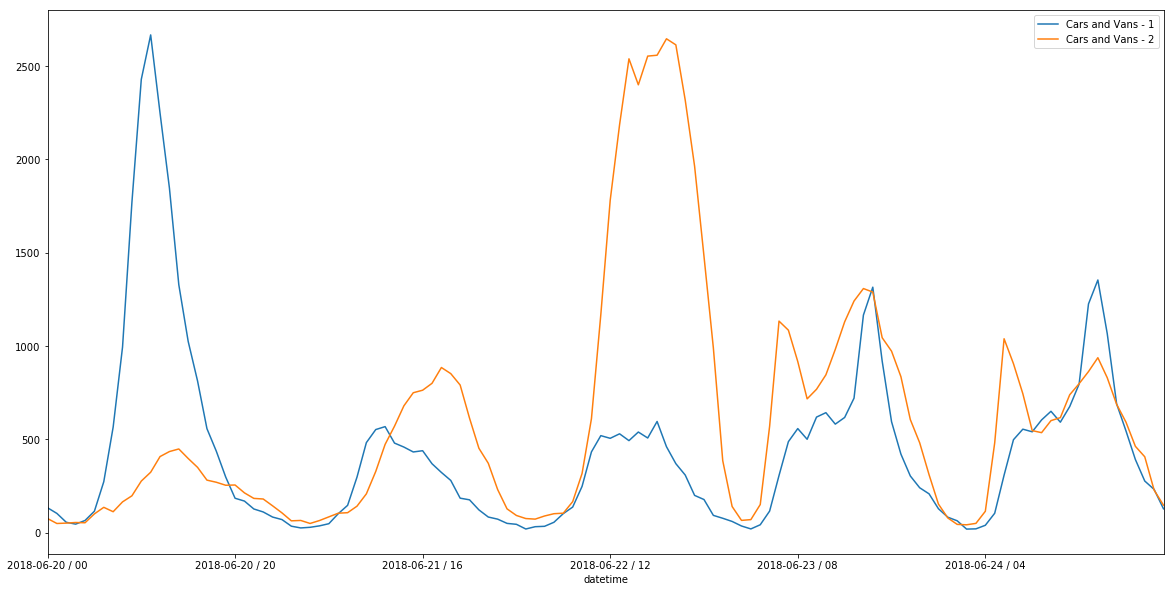

In [146]:
ts_format["datetime"] = ts_format.apply(lambda row: row["date"].strftime('%Y-%m-%d') + " / " + row["hour"][:2], axis=1)
fig, ax = plt.subplots(figsize=(20, 10))
ts_format[ts_format["LAM Station"] == "Mäntsälä"][["datetime", "Cars and Vans - 1", "Cars and Vans - 2"]].plot(x="datetime", kind="line", ax=ax)